<a href="https://colab.research.google.com/github/antonioenas/Denoising_HPatches_for_Descriptor_Learning/blob/master/5_complete_evaluation_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5) Evaluation - Deep learning coursework, Imperial College London
**Antonio Enas, 01070859, AE1115**


---

In this notebook, the user can load trained denoiser and descriptor models to evaluate their performance.

For qualitative evaluation, we propose the *joint hex plot* of the pairwise distances (anchor to positive and anchor to negative).
Furthermore, the validation set can be plotted in 2 dimensions with the respetive labels.

Structure:
1. Environment set up
2. Load pre trained models
3. Qualitative evaluation
4. Quantitative evaluation

# 1. Environment set up
This section ensures all libraries and dataset are correctly imported.

If data is already mounted select:
              `import_data = False`

In [0]:
import_data = False

### Optional GPU check

In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

### Cloning the repository and downloading the data

In [0]:
if import_data == False:
  # Change directory
  %cd /content/keras_triplet_descriptor
else:
  # Clone repo
  !git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
  %cd /content/keras_triplet_descriptor
  # Download data
  !wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  # Extract data
  !unzip -q ./hpatches_data.zip
  !rm ./hpatches_data.zip


### Importing Necessary Modules

In [0]:
!pip install -U seaborn

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams["patch.force_edgecolor"] = True

# To download files
from google.colab import files

from sklearn.decomposition import PCA
import pandas as pd

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 


# 2. Upload and load models to evaluate
Parameters needed:

*    `use_clean_bool` to evaluate using noisy or clean patches
*   `denoiser_to_eval`
*   `descripto_to_eval`

In [0]:
use_clean_bool = True

`denoiser_to_eval` needs to be the denoiser network model imported as `keras.models.load_model('./denoiser_model.h5')`.

`None` is allowed if `use_clean = True`.

In [0]:
denoiser_to_eval = None

`descriptor_notrip_eval` indicates the building block of the siamese triplet descriptor network, not the model trained on the triplets.


In [0]:
descriptor_notrip_eval = keras.models.load_model('bs_c_descriptor_e20.h5')

# 3. Qualitative evaluation
In this section we visualise the individual pair distances within each triplet onto the loss surface and the respective  loss distribiution.

### Generate the evaluation triplets for both qualitative and quantitative evaluation

In [0]:
hPatches = HPatches(train_fnames=train_fnames, denoise_model=denoiser_to_eval, test_fnames=test_fnames, use_clean=use_clean_bool)

In [0]:
# Specify how many triplets to consider
n_triplets = 10000

random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

# Generate a single large batch of triplets in the training set
eval_test_gen = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir,train=0), batch_size=50, num_triplets=n_triplets)


We create the model `eval_triplet`, which is built similarly to the descriptor triplet model. However, instead of returning the triplet loss between anchor, positive and negative patches, it returns the descriptor vectors themselves.

In [0]:
# Lossless triplet model to generate triplets for plots
shape = (32,32,1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')

ea = descriptor_notrip_eval(xa)
ep = descriptor_notrip_eval(xp)
en = descriptor_notrip_eval(xn)

eval_triplet = Model(inputs=[xa, xp, xn], outputs=[ea, ep, en])

## Calculate the distance distribution between positive and negative descriptor pairs

Calculate the euclidean distance between AP, AN pairs. Then evaluate how the distance pairs are distributed onto the loss surface.

The diagonal line indicates the boundary between the desired region (positive distances < negative distances) and undesired region (positive distances > negative distances).

In [0]:
# Generate the descriptor vectors for each anchor, positive and negative image
embedding_a, embedding_p, embedding_n = eval_triplet.predict_generator(eval_test_gen)

# Measure distances between triplets
positive_distance = np.mean((embedding_a-embedding_p)**2 , axis=-1)
negative_distance = np.mean((embedding_a-embedding_n)**2 , axis=-1)

<Figure size 144x360 with 0 Axes>

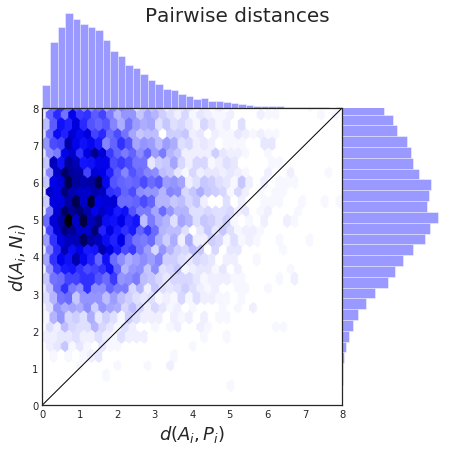

In [0]:
# Plot distance distribution
sns.set_style('ticks')
plt.figure(figsize=(2,5))
g = (sns.jointplot(x=positive_distance, y=negative_distance, kind="hex",color = 'b',
                   xlim = (0,8), ylim = (0,8), ratio = 3, space=0)
     .set_axis_labels("$d(A_i,P_i)$", "$d(A_i,N_i)$",fontsize=18))
g.fig.suptitle('Pairwise distances', fontsize=20)
g.ax_joint.plot([0,8], [0,8], 'k',linewidth = 1)

## Plot the descriptor vectors in 2D (PCA+tSNE), coloured based on their labels.
Dimensionality reduction through PCA+tSNE is applied to plot the descriptors in 2D.
Label mining is performed in order to increase the meaningfulness of the plot.

Attention: tSNE takes some time to run (about 5 minutes).

In [0]:
# Extract labels of each descriptor

a_labels = np.zeros((np.shape(eval_test_gen.triplets)[0],))
p_labels = np.zeros((np.shape(eval_test_gen.triplets)[0],))
n_labels = np.zeros((np.shape(eval_test_gen.triplets)[0],))

i = 0
for idx in eval_test_gen.triplets:
  a_labels[i] = eval_test_gen.labels[idx[0]]
  p_labels[i] = eval_test_gen.labels[idx[1]]
  n_labels[i] = eval_test_gen.labels[idx[2]]
  i += 1

In [0]:
# Map descriptor vectors and respective labels
vector_map = np.array([embedding_a, embedding_p, embedding_n ]).reshape(3*np.shape(eval_test_gen.triplets)[0],128)
labels_map = np.array([a_labels, p_labels, n_labels ]).reshape(3*np.shape(eval_test_gen.triplets)[0],)

To reduce the complexity of t-SNE dimensionality reduction, PCA is performed first.

We consider the first 20 principal components as they capture more than 90% of the data variance.

In [0]:
# Visualisethrough PCA
pca = PCA(n_components=20)
pca_result = pca.fit_transform(vector_map)


print('The first 20 principal components account for {} of the data variance' .format(np.sum(pca.explained_variance_ratio_)*100) )

The first 20 principal components account for 92.1512365341 of the data variance


In [0]:
import time

from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(pca_result)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.041s...
[t-SNE] Computed neighbors for 30000 samples in 39.536s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for s

The results of the t-SNE dimensionality reduction are stored in a Pandas DataFrame to ease plotting.

In [0]:
df_tsne = pd.DataFrame()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = labels_map

A scatterplot shows the bidimensional distribution of the descriptor vectors, with colours matching their original labels.

Text(0.5,1,'Descriptor vectors 2D reduction')

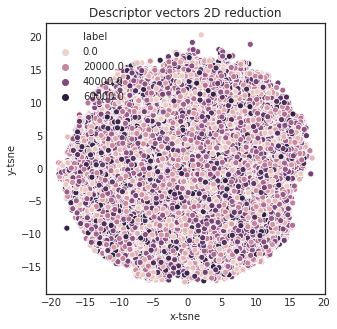

In [0]:
sns.set_style('ticks')
plt.figure(figsize=(5,5))
lm = sns.scatterplot(data=df_tsne, x='x-tsne', y='y-tsne', hue='label')

lm.set_title("Descriptor vectors 2D reduction", fontsize=12)



# 4. Quantitative evaluation
To evaluate the performance of out model we use the existing evaluation code  **HPatches benchmark**, which generates a .csv and then compute the three benchmarking metrics:


1.   Verification
2.   Matching
3.   Retrieval



## Generating descriptors files for test data 

In [0]:
generate_desc_csv(descriptor_notrip_eval, seqs_test, denoise_model=denoiser_to_eval, use_clean = use_clean_bool)

## Evaluating descriptors in HPatches Benchmark
We use HPatches benchmark code to compute the results for our model.

### Verification

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification


### Matching
Image matching, tests to what extent a descriptor can correctly identify correspondences in two images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching


### Retrieval
Retrieval tests how well a descriptor can match a query patch to a pool of patches extracted from many images.

In [0]:
!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval